<a href="https://colab.research.google.com/github/habib-roy/google-colab-source-code/blob/master/Nonton_TV_Digital_Di_Pangandaran.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Elevation chart from the house location to the transmitter tower location**

In [268]:
# Kebutuhan package
!pip install geopy
!pip install simplekml

import math
import folium
import requests
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from PIL import Image
from skimage import io
from simplekml import Kml, Color
from matplotlib.lines import Line2D
from shapely.geometry import Point, LineString
from geopy.distance import geodesic
from IPython.core.display import display, HTML

In [191]:
# Tipe data point
class PointLocation:
    def __init__(self, x=0, y=0):
        self.x = x
        self.y = y

In [185]:
# Lokasi rumah
pointHouse = PointLocation(-7.671661707828978, 108.6316692891957)

"""
Referensi lokasi pemancar TV Digital
- https://siarandigital.kominfo.go.id/wilayah-siaran-tv-digital
- https://public.tableau.com/app/profile/preps/viz/PetaISRTVDigital_16200120440100/DashboardISRTVDigital
"""

# Pemancar TVRI Pasir Koja
pointTowerPasirKoja = PointLocation(-7.477402690828831, 108.2379324231916)

# Pemancar TVRI Tambaksari
pointTowerTambaksari = PointLocation(-7.23833333, 108.53305556)

# Pemancar TVRI Banyumas
pointTowerBanyumas = PointLocation(-7.55611111, 109.25361111)

In [ ]:
# Fungsi untuk set lebar dan tinggi peta folium
def fit_map(m):
    data = m.get_root().render()
    data_fixed_height = data.replace('width: 100%;height: 100%', 'width: 100%').replace('height: 100.0%;', 'height: 450px;', 1)
    display(HTML(data_fixed_height))

In [202]:
# Menampilkan lokasi dalam peta
peta_lokasi = folium.Map(location=(-7.4887313, 108.5530646), height=450, zoom_start=11)

# Pengelompolkan data dalam layer
kelompok_layer_rumah = folium.FeatureGroup('Rumah').add_to(peta_lokasi)
kelompok_layer_tower = folium.FeatureGroup('Tower').add_to(peta_lokasi)
kelompok_layer_garis = folium.FeatureGroup('Garis').add_to(peta_lokasi)

# Menambahkan semua lokasi pada kelompok layer
folium.Marker((pointHouse.x, pointHouse.y), icon=folium.Icon(color='black', icon='fa-home', prefix='fa'), tooltip=folium.map.Tooltip(text='Rumah')).add_to(kelompok_layer_rumah)
folium.Marker((pointTowerPasirKoja.x, pointTowerPasirKoja.y), icon=folium.Icon(color='green', icon='fa-tower-cell', prefix='fa'), tooltip=folium.map.Tooltip(text='Tower Pasir Koja')).add_to(kelompok_layer_tower)
folium.Marker((pointTowerTambaksari.x, pointTowerTambaksari.y), icon=folium.Icon(color='orange', icon='fa-tower-cell', prefix='fa'), tooltip=folium.map.Tooltip(text='Tower Tambaksari')).add_to(kelompok_layer_tower)
folium.Marker((pointTowerBanyumas.x, pointTowerBanyumas.y), icon=folium.Icon(color='blue', icon='fa-tower-cell', prefix='fa'), tooltip=folium.map.Tooltip(text='Tower Banyumas')).add_to(kelompok_layer_tower)

# Menambahkan garis antar lokasi
folium.PolyLine(locations=[(pointHouse.x, pointHouse.y), (pointTowerPasirKoja.x, pointTowerPasirKoja.y)], color='green', tooltip=folium.map.Tooltip(text='Rumah - Tower Pasir Koja')).add_to(kelompok_layer_garis)
folium.PolyLine(locations=[(pointHouse.x, pointHouse.y), (pointTowerTambaksari.x, pointTowerTambaksari.y)], color='orange', tooltip=folium.map.Tooltip(text='Rumah - Tower Tambaksari')).add_to(kelompok_layer_garis)
folium.PolyLine(locations=[(pointHouse.x, pointHouse.y), (pointTowerBanyumas.x, pointTowerBanyumas.y)], color='blue', tooltip=folium.map.Tooltip(text='Rumah - Tower Banyumas')).add_to(kelompok_layer_garis)

# Fokus peta sesuai lokasi data
folium.FitOverlays().add_to(peta_lokasi)

# Menambahkan layer kontrol
folium.LayerControl().add_to(peta_lokasi)

# Menampilkan semua lokasi pada peta
fit_map(peta_lokasi)

In [ ]:

# Fungsi untuk generate interpolasi koordinat dari 2 lokasi dengan interval jarak yang ditentukan
def interpolasi_koordinat(lokasi_awal, lokasi_tujuan, interval_meter=250):

    # Menghitung jarak (meter)
    jarak = geodesic((lokasi_awal.x, lokasi_awal.y), (lokasi_tujuan.x, lokasi_tujuan.y)).meters

    # Menghitung jumlah koordinat interpolasi
    jumlah_koordinat = math.floor(jarak / interval_meter)

    # Variable kumpulan data koordinat interpolasi
    interpolated_points = []

    # Lokasi jarak
    lokasi_jarak = 0

    # Menghitung koordinat interpolasi & mendapatkan ketinggian
    for i in range(1, jumlah_koordinat + 1):
        fraction = i / jumlah_koordinat
        lat = lokasi_awal.x + (lokasi_tujuan.x - lokasi_awal.x) * fraction
        lon = lokasi_awal.y + (lokasi_tujuan.y - lokasi_awal.y) * fraction
        lokasi_jarak = lokasi_jarak + interval_meter

        # Mencari ketinggian dari open data rest api.open-meteo.com
        rest_api_elevation = requests.get('https://api.open-meteo.com/v1/elevation',params={'latitude': lat, 'longitude': lon})
        elevation = rest_api_elevation.json()

        # Mengumpulkan data koordinat interpolasi & ketinggian
        interpolated_points.append((lat, lon, elevation['elevation'][0], lokasi_jarak))

    # Hasil interpolasi koordinat berupa dataframe
    return jarak, pd.DataFrame(interpolated_points, columns=['x', 'y', 'z', 'jarak'])

In [187]:
# Generate koordinat interpolasi dan ketinggian
rumah_pasir_koja_jarak, rumah_pasir_koja_dataframe = interpolasi_koordinat(pointHouse, pointTowerPasirKoja, interval_meter=250)
rumah_tambaksari_jarak, rumah_tambaksari_dataframe = interpolasi_koordinat(pointHouse, pointTowerTambaksari, interval_meter=250)
rumah_banyumas_jarak, rumah_banyumas_dataframe = interpolasi_koordinat(pointHouse, pointTowerBanyumas, interval_meter=250)

In [ ]:

# fungsi untuk membuat data garis lurus ketinggian
def garis_lurus_ketinggian(dataframe):
    ketinggian_rumah = dataframe['z'].iloc[0]
    ketinggian_tower = dataframe['z'].iloc[-1]
    kenaikan_ketinggian = (ketinggian_tower - ketinggian_rumah) / len(dataframe)
    ketinggian_sekarang = ketinggian_rumah
    garis = []
    for i in range(0, len(dataframe)):
        ketinggian_sekarang = ketinggian_sekarang + kenaikan_ketinggian
        garis.append(ketinggian_sekarang)
    return dataframe.assign(garis=garis)

In [188]:
# Menambahkan garis lurus
dataframe_pasir_koja = garis_lurus_ketinggian(rumah_pasir_koja_dataframe)
dataframe_tambaksari = garis_lurus_ketinggian(rumah_tambaksari_dataframe)
dataframe_banyumas = garis_lurus_ketinggian(rumah_banyumas_dataframe)

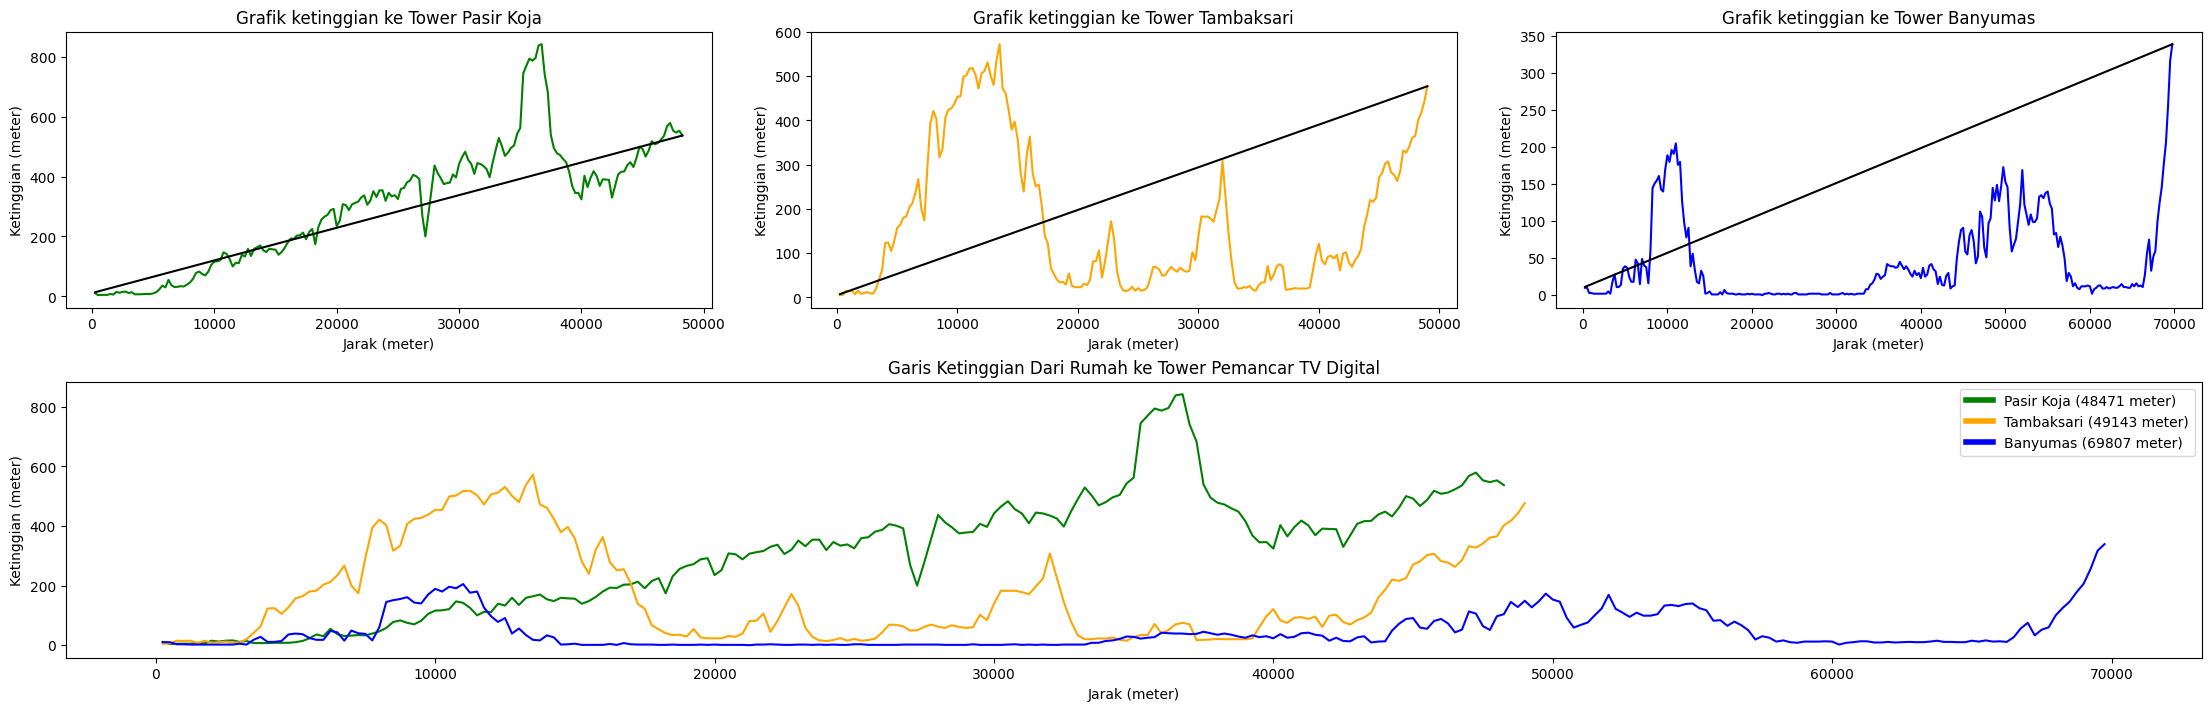

In [203]:
# Menampilkan data ketinggian dalam grafik
fig = plt.figure(figsize=(22, 7), layout='constrained')
axs = fig.subplot_mosaic([
    ['pasir_koja', 'tambaksari', 'banyumas'],
    ['gabung', 'gabung', 'gabung'],
])

# Data ketinggian ke tower pasir koja
axs['pasir_koja'].set_title('Grafik ketinggian ke Tower Pasir Koja')
axs['pasir_koja'].plot(dataframe_pasir_koja[dataframe_pasir_koja.columns[3]], dataframe_pasir_koja[dataframe_pasir_koja.columns[2]], color='green')
axs['pasir_koja'].plot(dataframe_pasir_koja[dataframe_pasir_koja.columns[3]], dataframe_pasir_koja[dataframe_pasir_koja.columns[4]], color='black')
axs['pasir_koja'].set_xlabel('Jarak (meter)')
axs['pasir_koja'].set_ylabel('Ketinggian (meter)')

# Data ketinggian ke tower tambaksari
axs['tambaksari'].set_title('Grafik ketinggian ke Tower Tambaksari')
axs['tambaksari'].plot(dataframe_tambaksari[dataframe_tambaksari.columns[3]], dataframe_tambaksari[dataframe_tambaksari.columns[2]], color='orange')
axs['tambaksari'].plot(dataframe_tambaksari[dataframe_tambaksari.columns[3]], dataframe_tambaksari[dataframe_tambaksari.columns[4]], color='black')
axs['tambaksari'].set_xlabel('Jarak (meter)')
axs['tambaksari'].set_ylabel('Ketinggian (meter)')

# Data ketinggian ke tower banyumas
axs['banyumas'].set_title('Grafik ketinggian ke Tower Banyumas')
axs['banyumas'].plot(dataframe_banyumas[dataframe_banyumas.columns[3]], dataframe_banyumas[dataframe_banyumas.columns[2]], color='blue')
axs['banyumas'].plot(dataframe_banyumas[dataframe_banyumas.columns[3]], dataframe_banyumas[dataframe_banyumas.columns[4]], color='black')
axs['banyumas'].set_xlabel('Jarak (meter)')
axs['banyumas'].set_ylabel('Ketinggian (meter)')

# Data ketinggian gabungan
axs['gabung'].set_title('Garis Ketinggian Dari Rumah ke Tower Pemancar TV Digital')
axs['gabung'].plot(dataframe_pasir_koja[dataframe_pasir_koja.columns[3]], dataframe_pasir_koja[dataframe_pasir_koja.columns[2]], color='green')
axs['gabung'].plot(dataframe_tambaksari[dataframe_tambaksari.columns[3]], dataframe_tambaksari[dataframe_tambaksari.columns[2]], color='orange')
axs['gabung'].plot(dataframe_banyumas[dataframe_banyumas.columns[3]], dataframe_banyumas[dataframe_banyumas.columns[2]], color='blue')
axs['gabung'].set_xlabel('Jarak (meter)')
axs['gabung'].set_ylabel('Ketinggian (meter)')
axs['gabung'].legend([ Line2D([0], [0], color='green', lw=4), Line2D([0], [0], color='orange', lw=4), Line2D([0], [0], color='blue', lw=4)], [f'Pasir Koja ({math.floor(rumah_pasir_koja_jarak)} meter)', f'Tambaksari ({math.floor(rumah_tambaksari_jarak)} meter)', f'Banyumas ({math.floor(rumah_banyumas_jarak)} meter)'])

In [ ]:
# fungsi untuk menampilkan data yang melebihi garis lurus
def melebihi_garis_lurus(dataframe):
    melebihi_garis = []
    for i in range(0, len(dataframe)):
        data = dataframe.iloc[i]
        if (data['z'] > data['garis']):
          melebihi_garis.append(data['z'])
        else:
          melebihi_garis.append(data['garis'])
    return dataframe.assign(melebihi_garis=melebihi_garis)

In [192]:
# Menampilkan lokasi yang melebihi garis lurus
dataframe_pasir_koja_melebihi_garis = melebihi_garis_lurus(dataframe_pasir_koja)
dataframe_tambaksari_melebihi_garis = melebihi_garis_lurus(dataframe_tambaksari)
dataframe_banyumas_melebihi_garis = melebihi_garis_lurus(dataframe_banyumas)

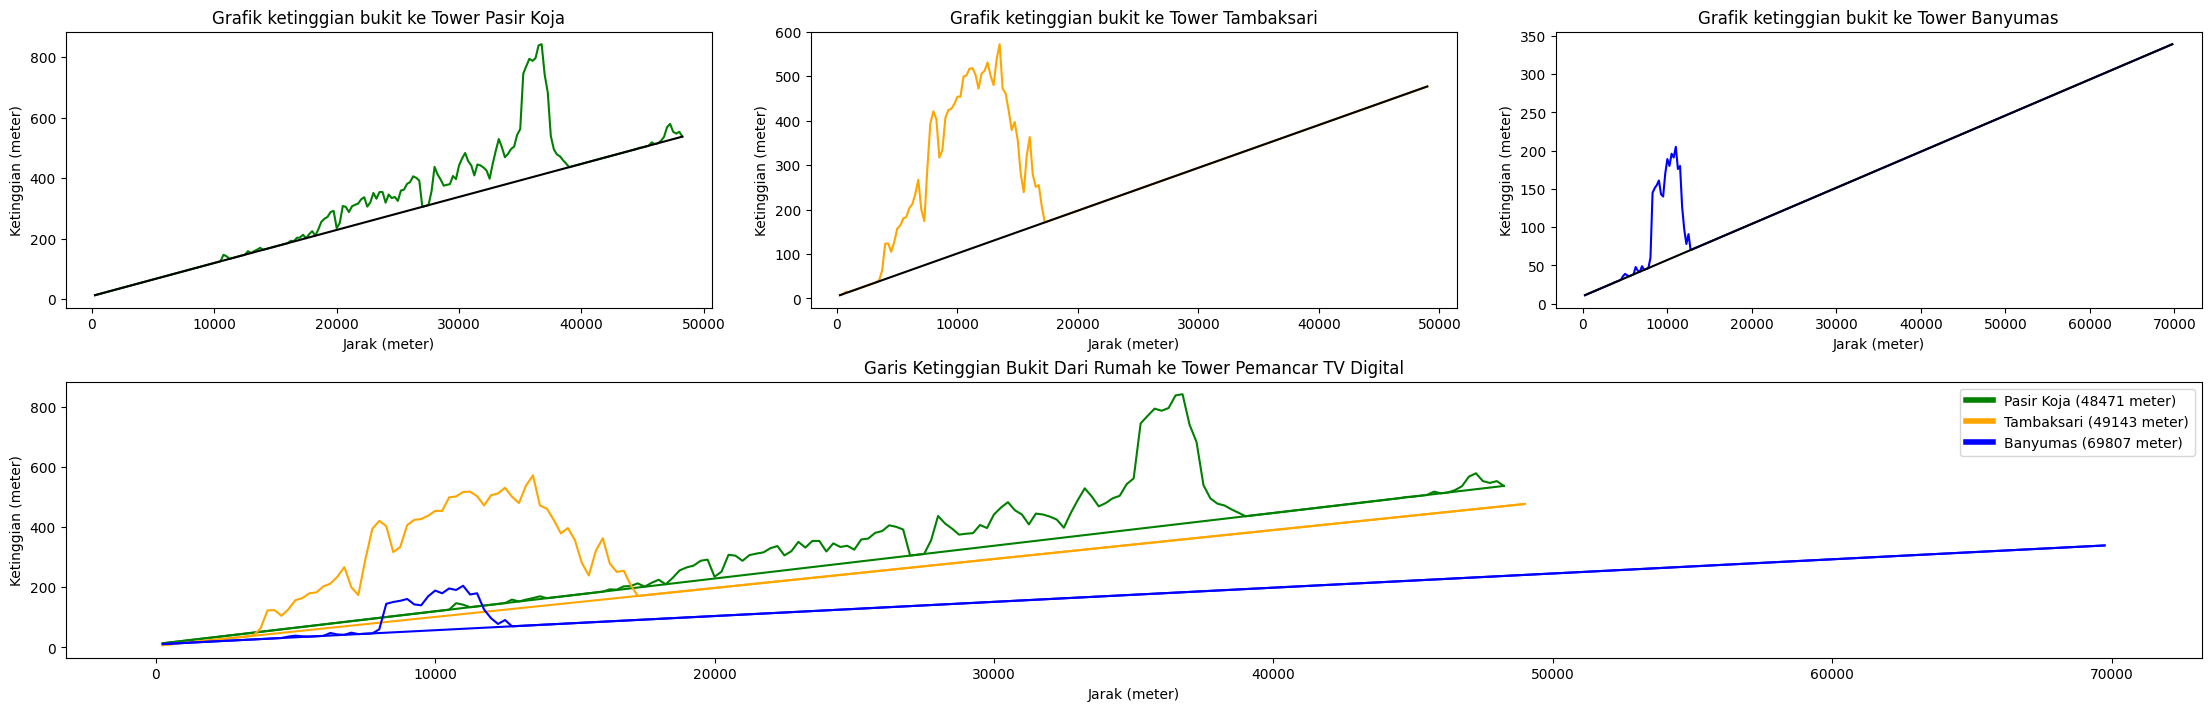

In [205]:
# Menampilkan data ketinggian dalam grafik
fig = plt.figure(figsize=(22, 7), layout='constrained')
axs = fig.subplot_mosaic([
    ['pasir_koja', 'tambaksari', 'banyumas'],
    ['gabung', 'gabung', 'gabung'],
])

# Data ketinggian ke tower pasir koja
axs['pasir_koja'].set_title('Grafik ketinggian bukit ke Tower Pasir Koja')
axs['pasir_koja'].plot(dataframe_pasir_koja_melebihi_garis[dataframe_pasir_koja_melebihi_garis.columns[3]], dataframe_pasir_koja_melebihi_garis[dataframe_pasir_koja_melebihi_garis.columns[5]], color='green')
axs['pasir_koja'].plot(dataframe_pasir_koja_melebihi_garis[dataframe_pasir_koja_melebihi_garis.columns[3]], dataframe_pasir_koja_melebihi_garis[dataframe_pasir_koja_melebihi_garis.columns[4]], color='black')
axs['pasir_koja'].set_xlabel('Jarak (meter)')
axs['pasir_koja'].set_ylabel('Ketinggian (meter)')

# Data ketinggian ke tower tambaksari
axs['tambaksari'].set_title('Grafik ketinggian bukit ke Tower Tambaksari')
axs['tambaksari'].plot(dataframe_tambaksari_melebihi_garis[dataframe_tambaksari_melebihi_garis.columns[3]], dataframe_tambaksari_melebihi_garis[dataframe_tambaksari_melebihi_garis.columns[5]], color='orange')
axs['tambaksari'].plot(dataframe_tambaksari_melebihi_garis[dataframe_tambaksari_melebihi_garis.columns[3]], dataframe_tambaksari_melebihi_garis[dataframe_tambaksari_melebihi_garis.columns[4]], color='black')
axs['tambaksari'].set_xlabel('Jarak (meter)')
axs['tambaksari'].set_ylabel('Ketinggian (meter)')

# Data ketinggian ke tower banyumas
axs['banyumas'].set_title('Grafik ketinggian bukit ke Tower Banyumas')
axs['banyumas'].plot(dataframe_banyumas_melebihi_garis[dataframe_banyumas_melebihi_garis.columns[3]], dataframe_banyumas_melebihi_garis[dataframe_banyumas_melebihi_garis.columns[5]], color='blue')
axs['banyumas'].plot(dataframe_banyumas_melebihi_garis[dataframe_banyumas_melebihi_garis.columns[3]], dataframe_banyumas_melebihi_garis[dataframe_banyumas_melebihi_garis.columns[4]], color='black')
axs['banyumas'].set_xlabel('Jarak (meter)')
axs['banyumas'].set_ylabel('Ketinggian (meter)')

# Data ketinggian gabungan
axs['gabung'].set_title('Garis Ketinggian Bukit Dari Rumah ke Tower Pemancar TV Digital')
axs['gabung'].plot(dataframe_pasir_koja_melebihi_garis[dataframe_pasir_koja_melebihi_garis.columns[3]], dataframe_pasir_koja_melebihi_garis[dataframe_pasir_koja_melebihi_garis.columns[5]], color='green')
axs['gabung'].plot(dataframe_pasir_koja_melebihi_garis[dataframe_pasir_koja_melebihi_garis.columns[3]], dataframe_pasir_koja_melebihi_garis[dataframe_pasir_koja_melebihi_garis.columns[4]], color='green')
axs['gabung'].plot(dataframe_tambaksari_melebihi_garis[dataframe_tambaksari_melebihi_garis.columns[3]], dataframe_tambaksari_melebihi_garis[dataframe_tambaksari_melebihi_garis.columns[5]], color='orange')
axs['gabung'].plot(dataframe_tambaksari_melebihi_garis[dataframe_tambaksari_melebihi_garis.columns[3]], dataframe_tambaksari_melebihi_garis[dataframe_tambaksari_melebihi_garis.columns[4]], color='orange')
axs['gabung'].plot(dataframe_banyumas_melebihi_garis[dataframe_banyumas_melebihi_garis.columns[3]], dataframe_banyumas_melebihi_garis[dataframe_banyumas_melebihi_garis.columns[5]], color='blue')
axs['gabung'].plot(dataframe_banyumas_melebihi_garis[dataframe_banyumas_melebihi_garis.columns[3]], dataframe_banyumas_melebihi_garis[dataframe_banyumas_melebihi_garis.columns[4]], color='blue')
axs['gabung'].set_xlabel('Jarak (meter)')
axs['gabung'].set_ylabel('Ketinggian (meter)')
axs['gabung'].legend([ Line2D([0], [0], color='green', lw=4), Line2D([0], [0], color='orange', lw=4), Line2D([0], [0], color='blue', lw=4)], [f'Pasir Koja ({math.floor(rumah_pasir_koja_jarak)} meter)', f'Tambaksari ({math.floor(rumah_tambaksari_jarak)} meter)', f'Banyumas ({math.floor(rumah_banyumas_jarak)} meter)'])

In [257]:
# Fungsi untuk mengambil koordinat yang ketinggiannya melebihi garis lurus
def koordinat_melebihi_garis_lurus(dataframe, name='kml'):
    koordinat_melebihi_garis_raw = []
    koordinat_melebihi_garis_raw_kml = []
    koordinat_melebihi_garis = []
    line = []
    line_kml = []
    kml = Kml(open=1)
    multiline = kml.newmultigeometry(name='MultiLine')
    for i in range(0, len(dataframe)):
        data = dataframe.iloc[i]
        if (data['z'] > data['garis']):
          line.append((data['x'], data['y']))
          line_kml.append((data['y'], data['x'], data['z']))
        else:
          koordinat_melebihi_garis_raw.append(line)
          koordinat_melebihi_garis_raw_kml.append(line_kml)
          line = []
          line_kml = []
          continue
    for row in koordinat_melebihi_garis_raw:
      if(len(row) > 1):
        koordinat_melebihi_garis.append(row)

    for row in koordinat_melebihi_garis_raw_kml:
      if(len(row) > 1):
        multiline.newlinestring(coords=row)

    # Membuat file KML untuk ditampilkan di https://earth.google.com
    multiline.style.linestyle.color = Color.red
    multiline.style.linestyle.width = 10
    kml.save(f'{name}.kml')

    return koordinat_melebihi_garis

In [258]:
# Menampilkan garis yang melebihi garis lurus
koordinat_pasir_koja_melebihi_garis = koordinat_melebihi_garis_lurus(dataframe_pasir_koja, name='pasir_koja')
koordinat_tambaksari_melebihi_garis = koordinat_melebihi_garis_lurus(dataframe_tambaksari, name='tambaksari')
koordinat_banyumas_melebihi_garis = koordinat_melebihi_garis_lurus(dataframe_banyumas, name='banyumas')

Text(0, 0.5, 'Ketinggian (meter)')

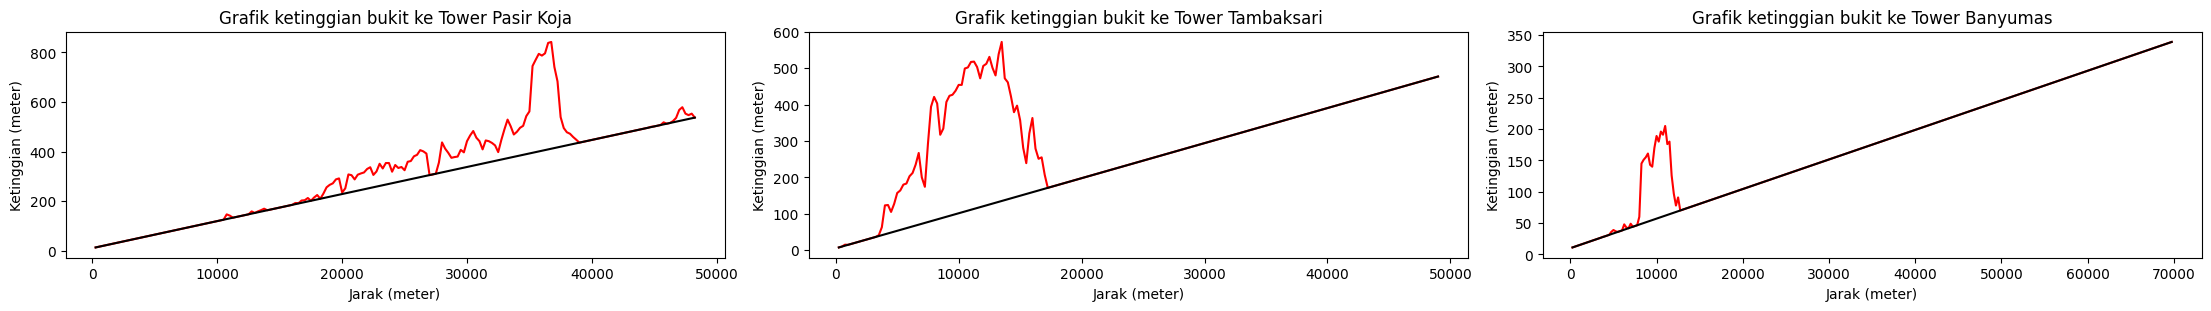

In [255]:
# Menampilkan lokasi dalam peta
peta = folium.Map(location=(-7.4887313, 108.5530646), height=450, zoom_start=11)

# Pengelompolkan data dalam layer
kelompok_layer_rumah = folium.FeatureGroup('Rumah').add_to(peta)
kelompok_layer_tower = folium.FeatureGroup('Tower').add_to(peta)
kelompok_layer_garis = folium.FeatureGroup('Garis').add_to(peta)
kelompok_layer_garis_bukit = folium.FeatureGroup('Garis Bukit').add_to(peta)

# Menambahkan semua lokasi pada kelompok layer
folium.Marker((pointHouse.x, pointHouse.y), icon=folium.Icon(color='black', icon='fa-home', prefix='fa'), tooltip=folium.map.Tooltip(text='Rumah')).add_to(kelompok_layer_rumah)
folium.Marker((pointTowerPasirKoja.x, pointTowerPasirKoja.y), icon=folium.Icon(color='green', icon='fa-tower-cell', prefix='fa'), tooltip=folium.map.Tooltip(text='Tower Pasir Koja')).add_to(kelompok_layer_tower)
folium.Marker((pointTowerTambaksari.x, pointTowerTambaksari.y), icon=folium.Icon(color='orange', icon='fa-tower-cell', prefix='fa'), tooltip=folium.map.Tooltip(text='Tower Tambaksari')).add_to(kelompok_layer_tower)
folium.Marker((pointTowerBanyumas.x, pointTowerBanyumas.y), icon=folium.Icon(color='blue', icon='fa-tower-cell', prefix='fa'), tooltip=folium.map.Tooltip(text='Tower Banyumas')).add_to(kelompok_layer_tower)

# Menambahkan garis antar lokasi
folium.PolyLine(locations=[(pointHouse.x, pointHouse.y), (pointTowerPasirKoja.x, pointTowerPasirKoja.y)], color='green', tooltip=folium.map.Tooltip(text='Rumah - Tower Pasir Koja')).add_to(kelompok_layer_garis)
folium.PolyLine(locations=[(pointHouse.x, pointHouse.y), (pointTowerTambaksari.x, pointTowerTambaksari.y)], color='orange', tooltip=folium.map.Tooltip(text='Rumah - Tower Tambaksari')).add_to(kelompok_layer_garis)
folium.PolyLine(locations=[(pointHouse.x, pointHouse.y), (pointTowerBanyumas.x, pointTowerBanyumas.y)], color='blue', tooltip=folium.map.Tooltip(text='Rumah - Tower Banyumas')).add_to(kelompok_layer_garis)

# Menambahkan garis bukit
for line in koordinat_pasir_koja_melebihi_garis:
  folium.PolyLine(locations=line, color='red', tooltip=folium.map.Tooltip(text='Bukit Pasir Koja')).add_to(kelompok_layer_garis_bukit)
for line in koordinat_tambaksari_melebihi_garis:
  folium.PolyLine(locations=line, color='red', tooltip=folium.map.Tooltip(text='Bukit Tambaksari')).add_to(kelompok_layer_garis_bukit)
for line in koordinat_banyumas_melebihi_garis:
  folium.PolyLine(locations=line, color='red', tooltip=folium.map.Tooltip(text='Bukit Banyumas')).add_to(kelompok_layer_garis_bukit)

# folium.Multi

# Fokus peta sesuai lokasi data
folium.FitOverlays().add_to(peta)

# Menambahkan layer kontrol
folium.LayerControl().add_to(peta)

# Menampilkan semua lokasi pada peta
fit_map(peta)

# Menampilkan data ketinggian dalam grafik
fig = plt.figure(figsize=(22, 3), layout='constrained')
axs = fig.subplot_mosaic([
    ['pasir_koja', 'tambaksari', 'banyumas'],
])

# Data ketinggian ke tower pasir koja
axs['pasir_koja'].set_title('Grafik ketinggian bukit ke Tower Pasir Koja')
axs['pasir_koja'].plot(dataframe_pasir_koja_melebihi_garis[dataframe_pasir_koja_melebihi_garis.columns[3]], dataframe_pasir_koja_melebihi_garis[dataframe_pasir_koja_melebihi_garis.columns[5]], color='red')
axs['pasir_koja'].plot(dataframe_pasir_koja_melebihi_garis[dataframe_pasir_koja_melebihi_garis.columns[3]], dataframe_pasir_koja_melebihi_garis[dataframe_pasir_koja_melebihi_garis.columns[4]], color='black')
axs['pasir_koja'].set_xlabel('Jarak (meter)')
axs['pasir_koja'].set_ylabel('Ketinggian (meter)')

# Data ketinggian ke tower tambaksari
axs['tambaksari'].set_title('Grafik ketinggian bukit ke Tower Tambaksari')
axs['tambaksari'].plot(dataframe_tambaksari_melebihi_garis[dataframe_tambaksari_melebihi_garis.columns[3]], dataframe_tambaksari_melebihi_garis[dataframe_tambaksari_melebihi_garis.columns[5]], color='red')
axs['tambaksari'].plot(dataframe_tambaksari_melebihi_garis[dataframe_tambaksari_melebihi_garis.columns[3]], dataframe_tambaksari_melebihi_garis[dataframe_tambaksari_melebihi_garis.columns[4]], color='black')
axs['tambaksari'].set_xlabel('Jarak (meter)')
axs['tambaksari'].set_ylabel('Ketinggian (meter)')

# Data ketinggian ke tower banyumas
axs['banyumas'].set_title('Grafik ketinggian bukit ke Tower Banyumas')
axs['banyumas'].plot(dataframe_banyumas_melebihi_garis[dataframe_banyumas_melebihi_garis.columns[3]], dataframe_banyumas_melebihi_garis[dataframe_banyumas_melebihi_garis.columns[5]], color='red')
axs['banyumas'].plot(dataframe_banyumas_melebihi_garis[dataframe_banyumas_melebihi_garis.columns[3]], dataframe_banyumas_melebihi_garis[dataframe_banyumas_melebihi_garis.columns[4]], color='black')
axs['banyumas'].set_xlabel('Jarak (meter)')
axs['banyumas'].set_ylabel('Ketinggian (meter)')

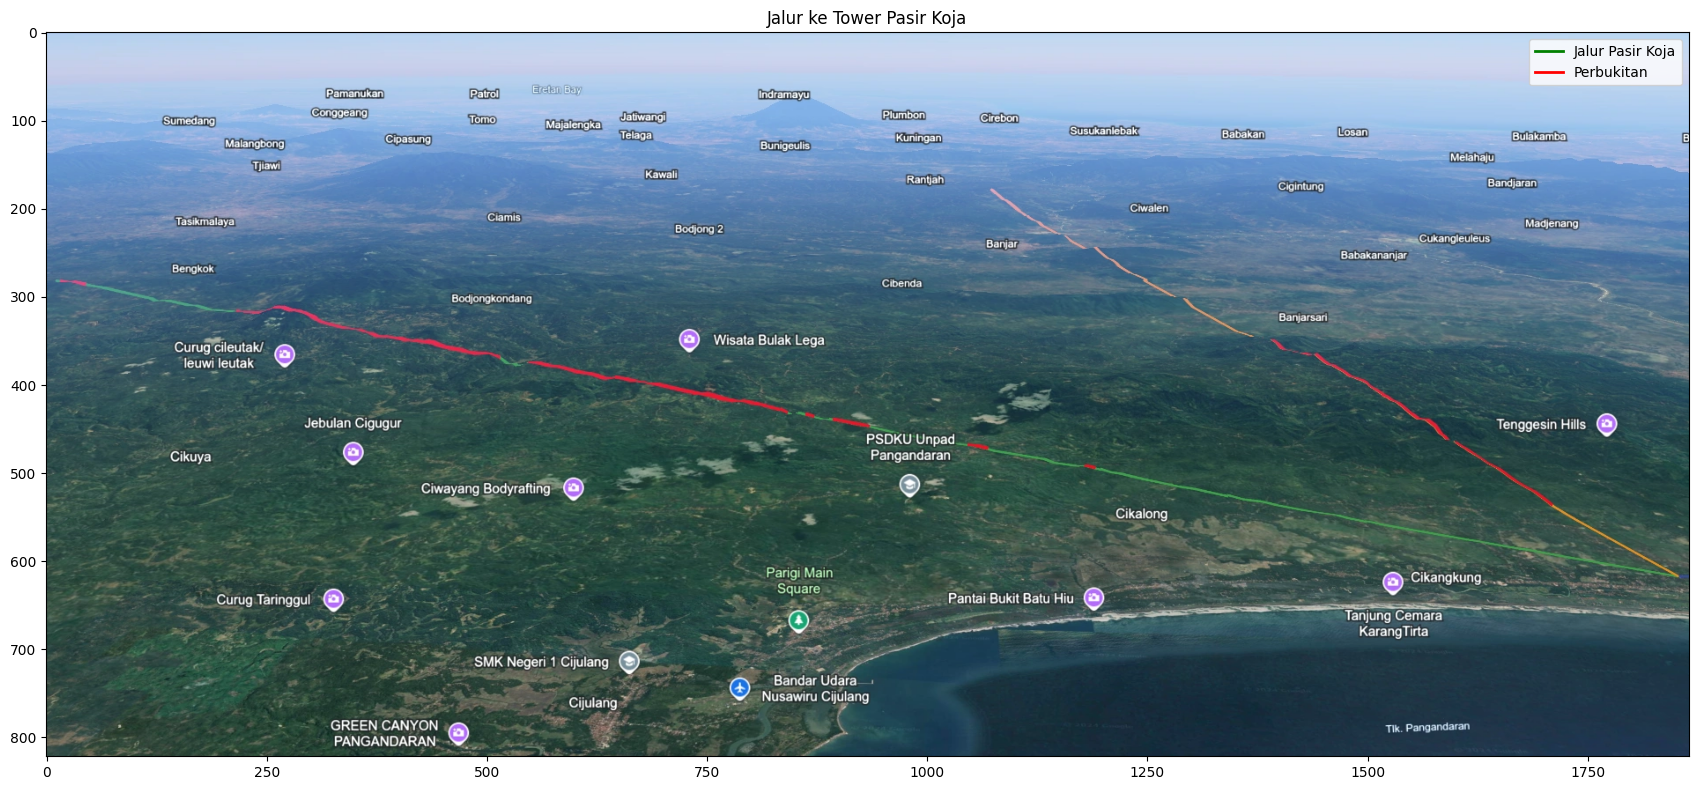

In [276]:
# Menampilkan hasil data KML pada https://earth.google.com
url_image_pasir_koja = 'https://i.ibb.co.com/pRbcxSC/pasir-koja.webp'
image_pasir_koja = io.imread(url_image_pasir_koja)
plt.imshow(image_pasir_koja)
plt.title('Jalur ke Tower Pasir Koja')
plt.legend([Line2D([0], [0], color='green', lw=2),Line2D([0], [0], color='red', lw=2)],[f'Jalur Pasir Koja',f'Perbukitan'])
plt.rcParams['figure.figsize'] = [42, 8]
plt.rcParams['figure.autolayout'] = True
plt.show()

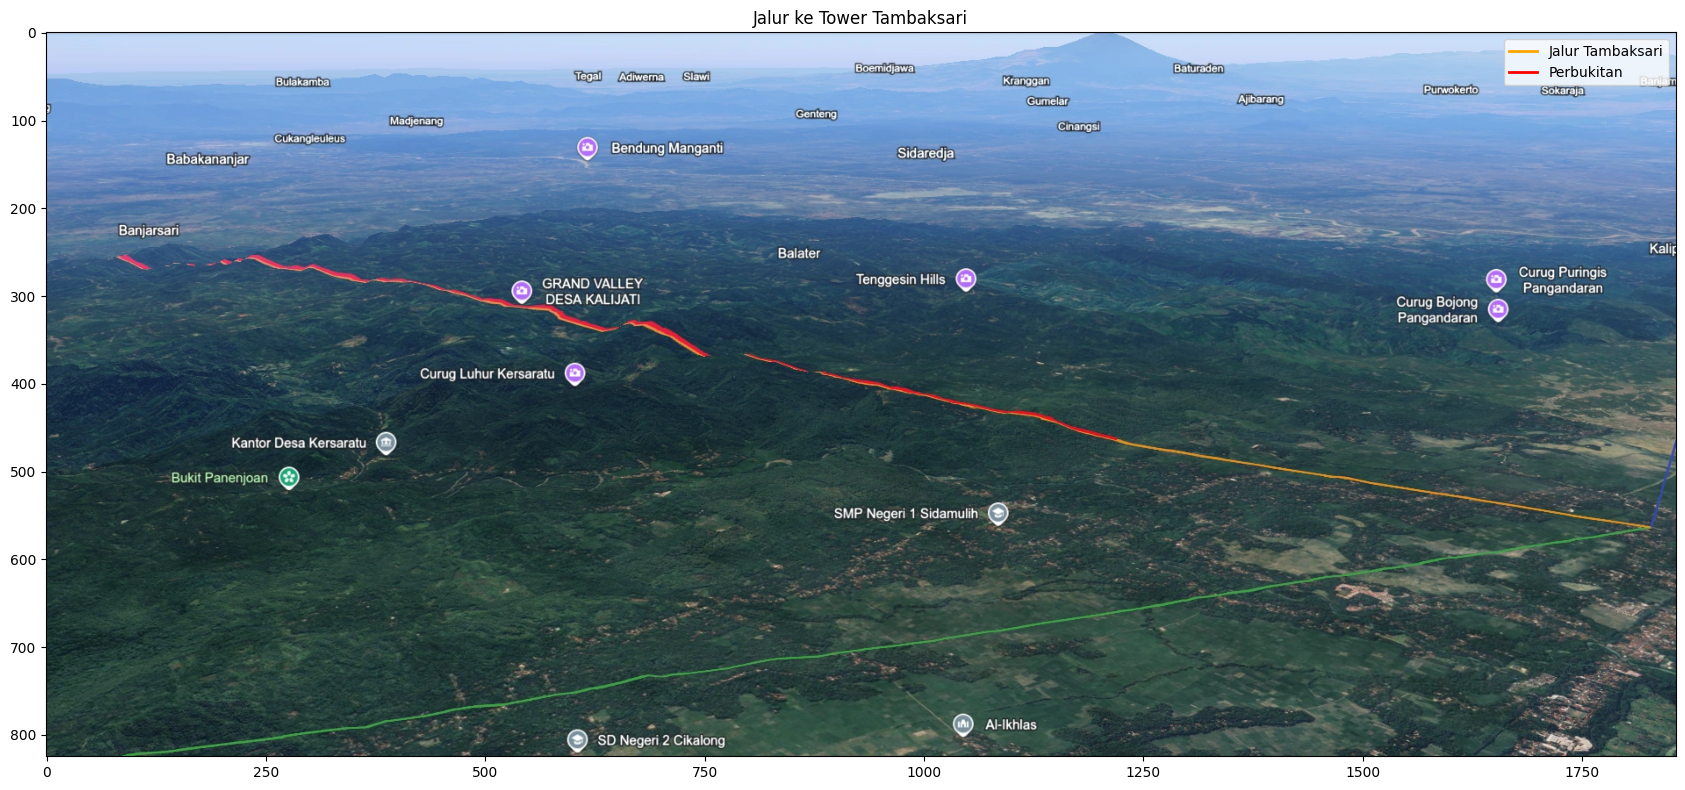

In [277]:
# Menampilkan hasil data KML pada https://earth.google.com
url_image_tambaksari = 'https://i.ibb.co.com/D5JzskX/tambaksari.webp'
image_tambaksari = io.imread(url_image_tambaksari)
plt.imshow(image_tambaksari)
plt.title('Jalur ke Tower Tambaksari')
plt.legend([Line2D([0], [0], color='orange', lw=2),Line2D([0], [0], color='red', lw=2)],[f'Jalur Tambaksari',f'Perbukitan'])
plt.rcParams['figure.figsize'] = [22, 8]
plt.rcParams['figure.autolayout'] = True
plt.show()

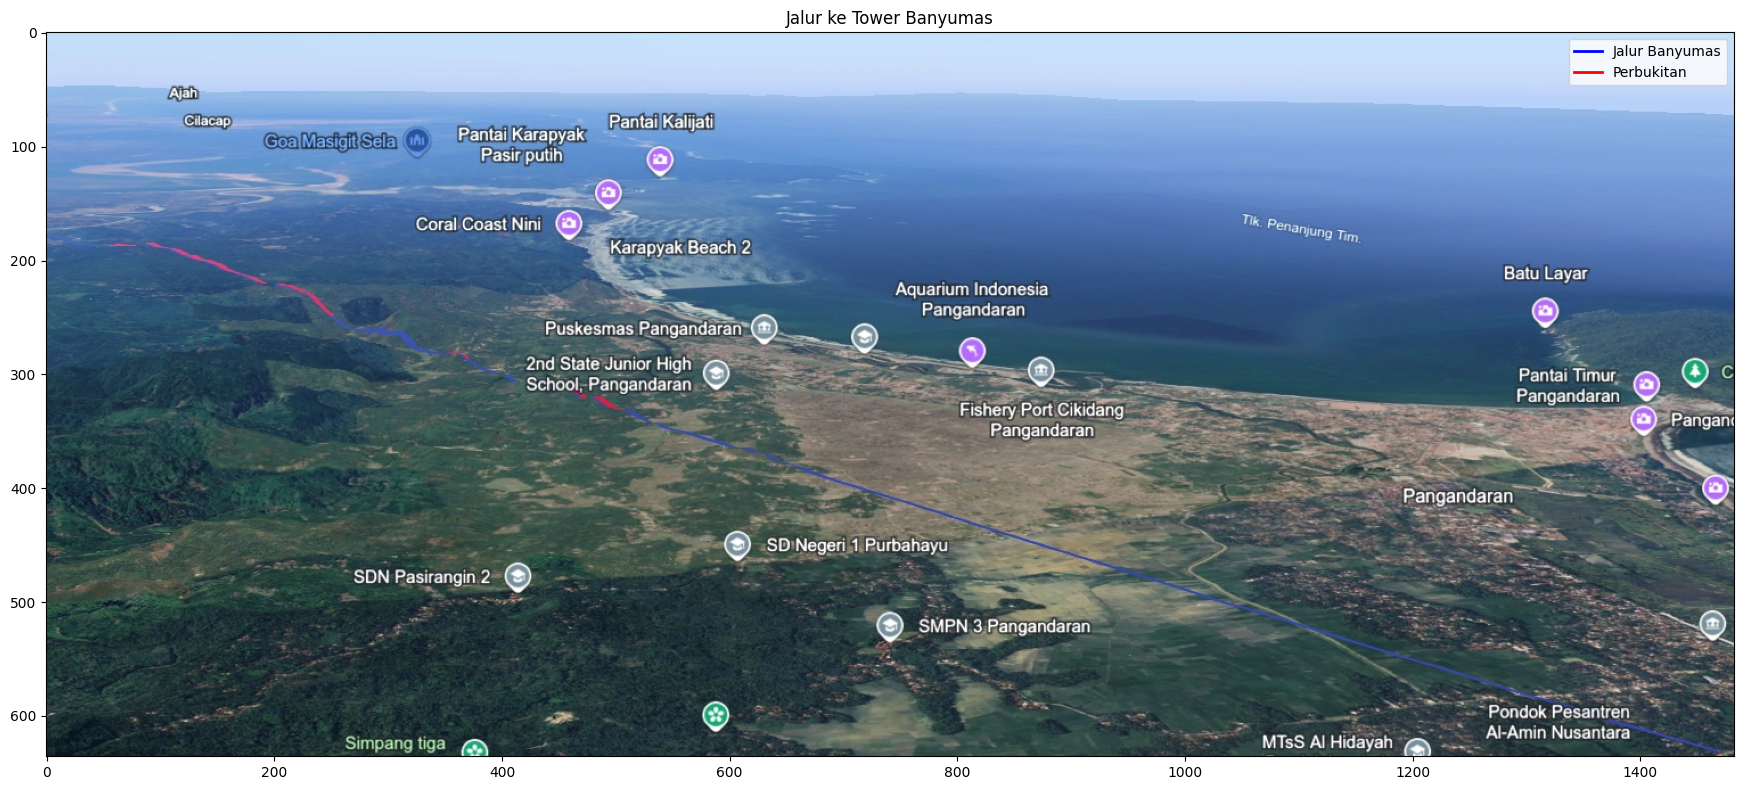

In [280]:
# Menampilkan hasil data KML pada https://earth.google.com
url_image_banyumas = 'https://i.ibb.co.com/nkKn2ZL/banyumas.webp'
image_banyumas = io.imread(url_image_banyumas)
plt.imshow(image_banyumas)
plt.title('Jalur ke Tower Banyumas')
plt.legend([Line2D([0], [0], color='blue', lw=2),Line2D([0], [0], color='red', lw=2)],[f'Jalur Banyumas',f'Perbukitan'])
plt.rcParams['figure.figsize'] = [17, 8]
plt.rcParams['figure.autolayout'] = True
plt.show()